Hubbard Atom
=======

We calculate the correlation functions 

$$\chi_{3,\sigma\sigma'}^{\rm PP} = \langle c^\dagger_\sigma (i\omega) c_\sigma (\tau=0^{+}) c^\dagger_{\sigma'} (i\Omega - i\omega) c_{\sigma'}(\tau=0) \rangle$$

and 

$$\chi_{3,\sigma\sigma'}^{\rm PH} = \langle c^\dagger_\sigma (i\omega) c_\sigma (i\Omega + i\omega) c^\dagger_{\sigma'} (\tau=0^{+}) c_{\sigma'}(\tau=0) \rangle$$

for the Hubbard atom with the Hamiltonian

$$h_{\rm loc} = h_0 + h_{\rm int}$$

where

$$h_0 = -\mu \, (n_{\uparrow, 0} + n_{\uparrow, 0}) - h(n_{\uparrow,0} - n_{\downarrow,0})$$

and

$$h_{\rm int} = U n_{\uparrow, 0} n_{\downarrow, 0}$$

The parameters are defined below.

In [1]:
# %load model.py
import sys, os
sys.path.append(os.getcwd() + '/../common')
from util import *

from pytriqs.gf import Gf, MeshImFreq, iOmega_n, inverse
from pytriqs.operators import c, c_dag, n
from itertools import product

# ==== System Parameters ====
beta = 5.           # Inverse temperature
mu = 2.             # Chemical potential
U = 5.              # On-site density-density interaction
h = 0.2             # Local magnetic field

# ==== Local Hamiltonian ====
h_0 = - mu*( n('up',0) + n('dn',0) ) - h*( n('up',0) - n('dn',0) )
h_int = U * n('up',0) * n('dn',0)
h_loc = h_0 + h_int

# ==== Bath & Coupling Hamiltonian ====
h_bath, h_coup = 0, 0

# ==== Total impurity hamiltonian and fundamental operators ====
h_imp = h_loc + h_coup + h_bath
fundamental_operators = [ c('dn',0), c('up',0) ] # FIXME To be extracted

# ==== Green function structure ====
gf_struct = [ ['up',[0]], ['dn',[0]] ] 

# ==== Hybridization Function ====
n_iw = 20
iw_mesh = MeshImFreq(beta, 'Fermion', n_iw)
Delta = BlockGf_from_struct(mesh=iw_mesh, struct=gf_struct)
Delta << 0.0; 

# ==== Non-Interacting Impurity Green function  ====
G0_iw = BlockGf_from_struct(mesh=iw_mesh, struct=gf_struct)
G0_iw['up'] << inverse(iOmega_n + mu + h) # FIXME Set tails explicitly
G0_iw['dn'] << inverse(iOmega_n + mu - h) # FIXME Set tails explicitly

for iw in iw_mesh:
    G0_iw['up'][iw] = 1.0 / (iw + mu + h - Delta['up'][iw])
    G0_iw['dn'][iw] = 1.0 / (iw + mu - h - Delta['dn'][iw])


Results
====

In [2]:
from pytriqs.plot.mpl_interface import oplot, plt
%matplotlib inline

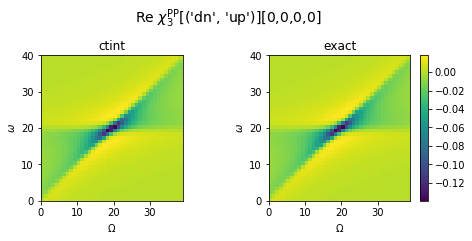

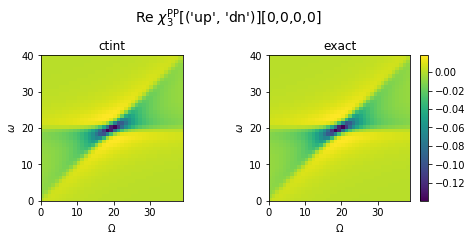

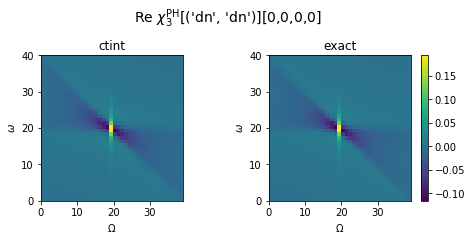

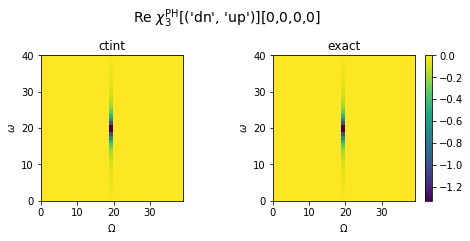

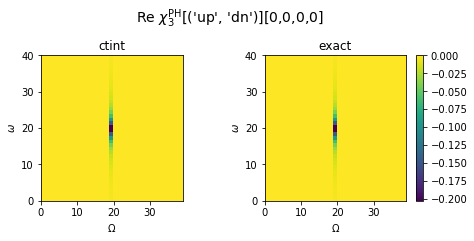

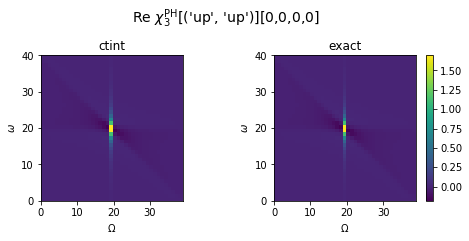

In [3]:
# %load ../common/plot.py
import sys, os
sys.path.append(os.getcwd() + "/..")
from model import *

from pytriqs.gf import Idx
from pytriqs.archive import HDFArchive
from pytriqs.plot.mpl_interface import oplot, plt
from glob import glob
from os.path import basename
import numpy as np

# === Load chi3pp and chi3ph for every solver

solver_lst = [ basename(f).strip('.h5') for f in glob('results/*.h5') ]
chi3pp_iw, chi3ph_iw = {}, {}

for solver in solver_lst:
    dat = HDFArchive('results/' + solver + '.h5','r')
    chi3pp_iw[solver] = dat['chi3pp_iw']
    chi3ph_iw[solver] = dat['chi3ph_iw']
    
# === For every block and solver, plot chi3pp and chi3ph

block_lst = [bl for bl in chi3pp_iw[solver_lst[0]].indices]
n_blocks = len(block_lst)
n_solvers = len(solver_lst)

for chi3, name in [[chi3pp_iw, r'$\chi_3^{\rm PP}$'], [chi3ph_iw, r'$\chi_3^{\rm PH}$']]:

    for block in block_lst:
        
        vmin = min([np.min(chi3[solver][block].data.real) for solver in solver_lst])
        vmax = max([np.max(chi3[solver][block].data.real) for solver in solver_lst])
        
        if vmin == vmax: continue
            
        plt.subplots(n_solvers, figsize=(3*n_solvers + 1,3))
        plt.suptitle("Re " + name + "[" + str(block) + r"][0,0,0,0]", fontsize=14, y=1.1)
        count = 1
        
        for solver in solver_lst:
            fig = plt.subplot(1, n_solvers, count); 
            plt.pcolormesh(chi3[solver][block].data[:,:,0,0,0,0].real, vmin=vmin, vmax=vmax)
            fig.set_title(solver)
            fig.axes.set_aspect('equal')
            plt.xlabel(r"$\Omega$")
            plt.ylabel(r"$\omega$")
            count += 1
            
        plt.colorbar() 
        plt.tight_layout()


Deviations
======

We present a table containing deviations between the different solvers measured via

$$||\chi_{3,\rm Solver_1} - \chi_{3,\rm Solver_2}||_\infty$$

In [4]:
import numpy as np

norm_inf = lambda chi3 : np.amax(np.abs(chi3.data))

for chi3, name in [[chi3pp_iw, 'chi_3^{PP}'], [chi3ph_iw, 'chi_3^{PH}']]:

    for block in block_lst:
        deviations = [[ norm_inf(chi3[s1][block] - chi3[s2][block]) for s1 in solver_lst ] \
                        for s2 in solver_lst ]
    
        print "\t\t    Deviations for " + name + str(block)
        print "\t\t -----------------------------------"

        row_format ="{:>15}" * (len(solver_lst) + 1)
        print row_format.format("", *solver_lst)
        row_format ="{:>15}" + "{:>15.2E}" * len(solver_lst)
        for solver, row in zip(solver_lst, deviations):
            print row_format.format(solver, *row)

        print "\n\n"

		    Deviations for chi_3^{PP}('dn', 'dn')
		 -----------------------------------
                         ctint          exact
          ctint       0.00E+00       0.00E+00
          exact       0.00E+00       0.00E+00



		    Deviations for chi_3^{PP}('dn', 'up')
		 -----------------------------------
                         ctint          exact
          ctint       0.00E+00       2.74E-03
          exact       2.74E-03       0.00E+00



		    Deviations for chi_3^{PP}('up', 'dn')
		 -----------------------------------
                         ctint          exact
          ctint       0.00E+00       2.74E-03
          exact       2.74E-03       0.00E+00



		    Deviations for chi_3^{PP}('up', 'up')
		 -----------------------------------
                         ctint          exact
          ctint       0.00E+00       0.00E+00
          exact       0.00E+00       0.00E+00



		    Deviations for chi_3^{PH}('dn', 'dn')
		 -----------------------------------
                     